# Klasifikasi Sekuensial dengan RNN & LSTM

Notebook ini mendemonstrasikan tugas klasifikasi sekuensial menggunakan Recurrent Neural Networks (RNN) dan Long Short-Term Memory (LSTM) di JAX dengan framework Flax NNX.

## Eksperimen Orde Temporal (QRSU)
Kita akan mereplikasi eksperimen dari Hochreiter & Schmidhuber (1997) yang menguji kemampuan jaringan saraf rekuren dalam menangkap ketergantungan temporal jangka panjang. Tugasnya adalah mengklasifikasikan urutan simbol berdasarkan urutan kemunculan simbol-simbol tertentu.

## Konsep Dasar Pemodelan Sekuensial

Data sekuensial adalah data di mana urutan kemunculan elemen sangat penting (misalnya: teks, audio, atau deret waktu). Untuk memodelkan data ini, kita membutuhkan arsitektur yang memiliki "memori" untuk mengingat informasi dari langkah waktu sebelumnya.

### 1. Vanilla Recurrent Neural Networks (RNN)

RNN bekerja dengan cara memproses elemen satu per satu sambil mempertahankan *hidden state* ($h_t$). *Hidden state* ini bertindak sebagai memori jangka pendek yang diperbarui pada setiap langkah waktu $t$:

$$h_t = \sigma(W_{hh} h_{t-1} + W_{xh} x_t + b_h)$$

Di mana:
- $x_t$ adalah input pada waktu $t$.
- $h_{t-1}$ adalah memori dari langkah sebelumnya.
- $\sigma$ adalah fungsi aktivasi (biasanya tanh atau ReLU).

**Kelemahan RNN:** Mengalami masalah *Vanishing Gradient*, di mana sinyal gradien mengecil secara eksponensial saat merambat mundur melalui waktu yang lama, sehingga sulit untuk mempelajari ketergantungan jangka panjang (long-term dependencies).

### 2. Long Short-Term Memory (LSTM)

LSTM dirancang khusus untuk mengatasi masalah *vanishing gradient* dengan memperkenalkan *Cell State* ($c_t$) dan mekanisme pintu (*gating system*):

- **Forget Gate ($f_t$):** Menentukan informasi apa yang harus dibuang dari memori.
- **Input Gate ($i_t$):** Menentukan informasi baru apa yang akan disimpan ke dalam memori.
- **Output Gate ($o_t$):** Menentukan apa yang akan dikeluarkan sebagai *hidden state* $h_t$ selanjutnya.

Aliran informasi dalam LSTM dikontrol oleh operasi perkalian elemen-per-elemen, memungkinkan informasi tetap tersimpan atau dibuang dengan sangat selektif selama ribuan langkah waktu.

### 3. Arsitektur Klasifikasi Sekuensial

Dalam tugas klasifikasi ini, kita menggunakan pendekatan **Many-to-One**:
1. Seluruh urutan $x_1, x_2, ..., x_T$ dimasukkan ke dalam RNN/LSTM.
2. Kita mengambil *hidden state* terakhir ($h_T$) yang diasumsikan sebagai ringkasan (vektor representasi) dari seluruh urutan tersebut.
3. Vektor $h_T$ dimasukkan ke lapisan *Linear* (Fully Connected) untuk menghasilkan probabilitas kelas melalui fungsi Softmax.

### Langkah 1: Pengaturan Awal

In [1]:
import sys, os
from time import process_time
import numpy as np
import json
from tqdm.notebook import tqdm

import jax
import jax.numpy as jnp
from flax import nnx
import optax

# Menambahkan parent directory ke path agar bisa import modul lokal
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
from sequential_tasks import TemporalOrderExp6aSequence as QRSU
from model_utils import save_checkpoint, load_checkpoint

### Langkah 2: Konfigurasi Dataset

In [2]:
max_epochs = 100
model_type = "lstm" # atau "rnn"
difficulty = "easy"
batch_size = 32

difficulty_levels = {
    "easy": QRSU.DifficultyLevel.EASY,
    "normal": QRSU.DifficultyLevel.NORMAL,
    "moderate": QRSU.DifficultyLevel.MODERATE,
    "hard": QRSU.DifficultyLevel.HARD,
    "nightmare": QRSU.DifficultyLevel.NIGHTMARE
}

difficulty_level = difficulty_levels.get(difficulty, QRSU.DifficultyLevel.EASY)

# Setup generator data
train_data_gen = QRSU.get_predefined_generator(difficulty_level, batch_size)
test_data_gen = QRSU.get_predefined_generator(difficulty_level, batch_size)
MODEL_DIR = "../models"

checkpoint_dir = f"{MODEL_DIR}/seq_classification"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

### Langkah 3: Definisi Model

Di bawah ini adalah implementasi `SimpleRNN` dan `SimpleLSTM` menggunakan Flax NNX.

In [3]:
class SimpleRNN(nnx.Module):
    def __init__(self, input_size, hidden_size, output_size, rngs: nnx.Rngs):
        self.rnn_cell = nnx.SimpleCell(input_size, hidden_size, rngs=rngs)
        self.linear = nnx.Linear(hidden_size, output_size, rngs=rngs)
        self.hidden_size = hidden_size
    
    def __call__(self, x):
        batch_size, seq_len, _ = x.shape
        h = jnp.zeros((batch_size, self.hidden_size))
        h_list = []
        for t in range(seq_len):
            h, h_out = self.rnn_cell(h, x[:, t, :])
            h = nnx.relu(h)
            h_list.append(h)
        h_stacked = jnp.stack(h_list, axis=1)
        return self.linear(h_stacked)

class SimpleLSTM(nnx.Module):
    def __init__(self, input_size, hidden_size, output_size, rngs: nnx.Rngs):
        self.lstm_cell = nnx.LSTMCell(input_size, hidden_size, rngs=rngs)
        self.linear = nnx.Linear(hidden_size, output_size, rngs=rngs)
        self.hidden_size = hidden_size
    
    def __call__(self, x):
        batch_size, seq_len, _ = x.shape
        h = jnp.zeros((batch_size, self.hidden_size))
        c = jnp.zeros((batch_size, self.hidden_size))
        h_list = []
        for t in range(seq_len):
            (h, c), h_out = self.lstm_cell((h, c), x[:, t, :])
            h_list.append(h_out)
        h_stacked = jnp.stack(h_list, axis=1)
        return self.linear(h_stacked)

### Langkah 4: Fungsi Pelatihan

Fungsi `train_step` menangani penghitungan gradien dan pembaruan bobot, sedangkan `train_epoch` mengulangi proses tersebut untuk seluruh dataset.

In [4]:
def train_step(model, optimizer, metrics, batch):
    inputs, targets = batch
    
    def loss_fn(model):
        logits = model(inputs)[:, -1, :] # Ambil output terakhir
        target_idx = jnp.argmax(targets, axis=1)
        loss = optax.softmax_cross_entropy_with_integer_labels(logits, target_idx).mean()
        return loss, logits

    (loss, logits), grads = nnx.value_and_grad(loss_fn, has_aux=True)(model)
    optimizer.update(model, grads)
    
    target_idx = jnp.argmax(targets, axis=1)
    metrics.update(values=loss, logits=logits, labels=target_idx)
    return loss

@nnx.jit
def eval_step(model, metrics, batch):
    inputs, targets = batch
    logits = model(inputs)[:, -1, :]
    target_idx = jnp.argmax(targets, axis=1)
    loss = optax.softmax_cross_entropy_with_integer_labels(logits, target_idx).mean()
    metrics.update(values=loss, logits=logits, labels=target_idx)
    return loss

def train_epoch(model, datagen, optimizer, metrics):
    model.train()
    total_loss = 0.
    for idx in range(len(datagen)):
        x, y = datagen[idx]
        loss = train_step(model, optimizer, metrics, (jnp.array(x), jnp.array(y)))
        total_loss += loss.item()
    return total_loss / len(datagen)

def evaluate(model, datagen, metrics):
    model.eval()
    total_loss = 0.
    for idx in range(len(datagen)):
        x, y = datagen[idx]
        loss = eval_step(model, metrics, (jnp.array(x), jnp.array(y)))
        total_loss += loss.item()
    return total_loss / len(datagen)

### Langkah 5: Inisialisasi Model & Optimizer

In [5]:
input_size = train_data_gen.n_symbols
hidden_size = 64
output_size = train_data_gen.n_classes    

rngs = nnx.Rngs(42)
if model_type == "rnn":
    model = SimpleRNN(input_size, hidden_size, output_size, rngs=rngs)
else:
    model = SimpleLSTM(input_size, hidden_size, output_size, rngs=rngs)

optimizer = nnx.Optimizer(model, optax.adam(1e-4), wrt=nnx.Param)
metrics = nnx.MultiMetric(
    loss=nnx.metrics.Average(),
    accuracy=nnx.metrics.Accuracy(),
)

history = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}

### Langkah 6: Loop Pelatihan Utama

In [6]:
print(f"Memulai pelatihan {model_type} pada tingkat kesulitan {difficulty}...")

for ep in tqdm(range(max_epochs), unit="epoch"):
    metrics.reset()
    train_loss = train_epoch(model, train_data_gen, optimizer, metrics)
    train_acc = metrics.compute()["accuracy"]
    
    metrics.reset()
    test_loss = evaluate(model, test_data_gen, metrics)
    test_acc = metrics.compute()["accuracy"]
    
    history["train_loss"].append(float(train_loss))
    history["train_acc"].append(float(train_acc))
    history["test_loss"].append(float(test_loss))
    history["test_acc"].append(float(test_acc))

    # Simpan checkpoint setiap epoch
    if (ep + 1) % 10 == 0:
        save_checkpoint(model, ep + 1, filedir=checkpoint_dir)
        print(f"Epoch {ep+1}: Loss={train_loss:.4f}, Acc={train_acc:.4f}, Test Acc={test_acc:.4f}")


Memulai pelatihan lstm pada tingkat kesulitan easy...


  0%|          | 0/100 [00:00<?, ?epoch/s]

Model disimpan ke ../models/seq_classification/epoch_1.safetensors
Model disimpan ke ../models/seq_classification/epoch_2.safetensors
Model disimpan ke ../models/seq_classification/epoch_3.safetensors
Model disimpan ke ../models/seq_classification/epoch_4.safetensors
Model disimpan ke ../models/seq_classification/epoch_5.safetensors
Model disimpan ke ../models/seq_classification/epoch_6.safetensors
Model disimpan ke ../models/seq_classification/epoch_7.safetensors
Model disimpan ke ../models/seq_classification/epoch_8.safetensors
Model disimpan ke ../models/seq_classification/epoch_9.safetensors
Model disimpan ke ../models/seq_classification/epoch_10.safetensors
Epoch 10: Loss=1.2088, Acc=0.7802, Test Acc=0.8165
Model disimpan ke ../models/seq_classification/epoch_11.safetensors
Model disimpan ke ../models/seq_classification/epoch_12.safetensors
Model disimpan ke ../models/seq_classification/epoch_13.safetensors
Model disimpan ke ../models/seq_classification/epoch_14.safetensors
Model 

### Langkah 7: Visualisasi Hasil

Meninjau grafik akurasi dan loss untuk melihat seberapa cepat model belajar.

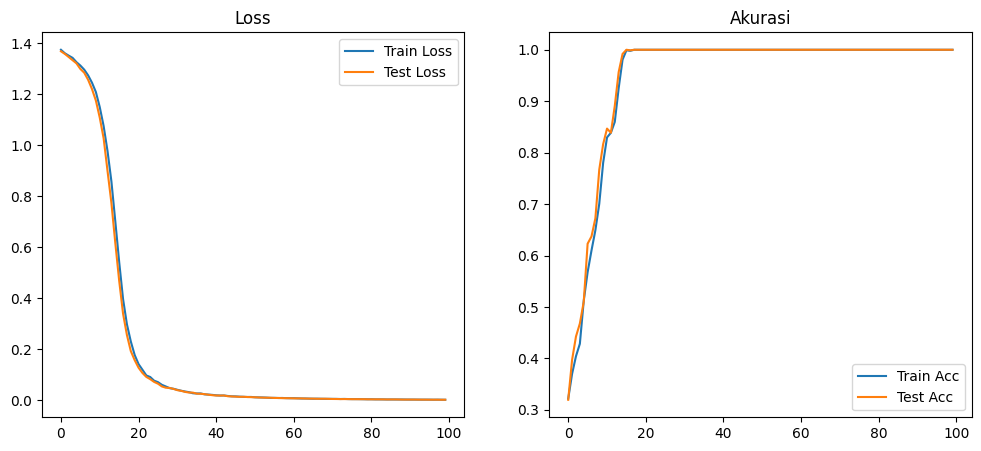

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["test_loss"], label="Test Loss")
plt.title("Loss"); plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["test_acc"], label="Test Acc")
plt.title("Akurasi"); plt.legend()
plt.show()

### Langkah 8: Menyimpan dan Memuat Model

Salah satu aspek penting dalam deep learning adalah kemampuan untuk menyimpan state model (parameter) sehingga kita tidak perlu melatih ulang dari awal. Kita menggunakan format `safetensors` karena aman, efisien, dan cepat.

**Alasan Menggunakan Safetensors:**
1.  **Keamanan**: Tidak mengizinkan eksekusi kode saat memuat (berbeda dengan `pickle`).
2.  **Efisiensi**: *Zero-copy* saat memuat ke memori, sangat cepat terutama untuk model besar.
3.  **Interoperabilitas**: Format standar yang didukung banyak framework (PyTorch, JAX, TensorFlow).

In [8]:
# Demo Memuat Model
print("Mencoba memuat model dari checkpoint terakhir...")
checkpoint_path = f"{checkpoint_dir}/epoch_{max_epochs}.safetensors"

# 1. Inisialisasi model baru dengan arsitektur yang sama
# Pastikan rngs diinisialisasi ulang
new_rngs = nnx.Rngs(0)
if model_type == "rnn":
    model_baru = SimpleRNN(input_size, hidden_size, output_size, rngs=new_rngs)
else:
    model_baru = SimpleLSTM(input_size, hidden_size, output_size, rngs=new_rngs)

# 2. Muat parameter
load_checkpoint(model_baru, checkpoint_path)

# 3. Verifikasi: Output harus identik dengan model asli
# Ambil satu batch testing
x_test, y_test = test_data_gen[0]
test_input = jnp.array(x_test)

model.eval()
model_baru.eval()

output_asli = model(test_input)[:, -1, :]
output_baru = model_baru(test_input)[:, -1, :]

diff = jnp.abs(output_asli - output_baru).max()
print(f"Perbedaan maksimum output: {diff:.6f}")

if diff < 1e-5:
    print("VERIFIKASI BERHASIL: Model dimuat dengan benar!")
else:
    print("VERIFIKASI GAGAL: Ada perbedaan output.")

Mencoba memuat model dari checkpoint terakhir...
Model dimuat dari ../models/seq_classification/epoch_100.safetensors
Perbedaan maksimum output: 0.000000
VERIFIKASI BERHASIL: Model dimuat dengan benar!
